# Working with pylila

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting-everything-up" data-toc-modified-id="Setting-everything-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting everything up</a></span></li><li><span><a href="#Exploring-the-lemma-bank" data-toc-modified-id="Exploring-the-lemma-bank-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploring the lemma bank</a></span><ul class="toc-item"><li><span><a href="#The-lemma:-overview" data-toc-modified-id="The-lemma:-overview-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The lemma: overview</a></span></li><li><span><a href="#Derivational-Morphology" data-toc-modified-id="Derivational-Morphology-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Derivational Morphology</a></span></li><li><span><a href="#Get-lemmas-from-string" data-toc-modified-id="Get-lemmas-from-string-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Get lemmas from string</a></span></li></ul></li></ul></div>

## Setting everything up 

First, we need to install and import the library. If you're working with the bleeding edge version (like I'm doing now) you'll need to add the project folder to your PYTHONPATH

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("../"))

sys.path

['/Users/francesco.mambrini/Documents/progetti/PyLiLa',
 '/Users/francesco.mambrini/Documents/progetti/PyLiLa/examples',
 '/opt/homebrew/Caskroom/miniforge/base/envs/lila/lib/python39.zip',
 '/opt/homebrew/Caskroom/miniforge/base/envs/lila/lib/python3.9',
 '/opt/homebrew/Caskroom/miniforge/base/envs/lila/lib/python3.9/lib-dynload',
 '',
 '/Users/francesco.mambrini/.local/lib/python3.9/site-packages',
 '/opt/homebrew/Caskroom/miniforge/base/envs/lila/lib/python3.9/site-packages',
 '/opt/homebrew/Caskroom/miniforge/base/envs/lila/lib/python3.9/site-packages/IPython/extensions',
 '/Users/francesco.mambrini/.ipython']

Now, the following line should work

In [2]:
import pylila

## Exploring the lemma bank

### The lemma: overview

In [3]:
from pylila.lemma import Lemma
from pprint import pprint

As with everything LiLa, the lemma is our starting point! Let's grab the URI of a lemma from the web and start exploring.

For instance, let's start from the verb "magnifico" (*magnify* or *value greatly*): 'http://lila-erc.eu/data/id/lemma/111306'

(In the next sections we'll see how to get some random sample, or how to get the URI(s) starting from the "written representation" of a Lemma. You can also use our [query interface](https://lila-erc.eu/query/) to look for lemmas)

In [4]:
l = Lemma("http://lila-erc.eu/data/id/lemma/111306")

Now we have our lemma! This object has a series of interesting properties. The list (tuple) of Ontolex' [written representations](https://www.w3.org/2016/05/ontolex/#writtenRep), or the RDFS label(s) for instance:

In [5]:
print(f"Written reps: {l.written_representations}")
print(f"Label(s): {l.labels}")

Written reps: (rdflib.term.Literal('magnufico'), rdflib.term.Literal('magnifico'))
Label(s): (rdflib.term.Literal('magnifico'),)


As you see, all values are returned as Literals or URIs of the python `rflib` library. There's also a method to get the label(s) as a single string:

In [6]:
print(l.get_label())
print(l.get_written_representations())

magnifico
magnufico, magnifico


The `Lemma` object is contructed like that: first, the URI is parsed and the online SPARQL endpoint of LiLa is interrogated. An `rdflib.Graph` is contructed with all the triples that have the given lemma's URI as subject. The graph is accessible from the `l.graph` property:

In [7]:
g = l.graph
print(type(g))

<class 'rdflib.graph.Graph'>


You can generate a visualization of the data in `l.graph`, using the following code, but you'll need a couple of external libraries (`pydotplus` and the `graphviz` binding), plus obvioulsy the [Graphviz](https://graphviz.org/) binaries:

In [8]:
from IPython.display import display, Image

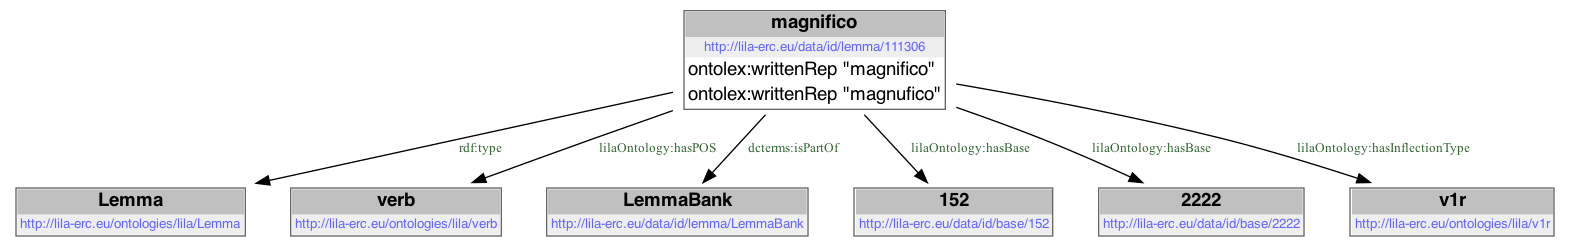

In [9]:
import io
import pydotplus
from rdflib.tools.rdf2dot import rdf2dot

stream = io.StringIO()
rdf2dot(g, stream, opts = {display})
dg = pydotplus.graph_from_dot_data(stream.getvalue())
png = dg.create_png()
display(Image(png))

If you didn't manage to run the code above, just load the pre-gerated graph

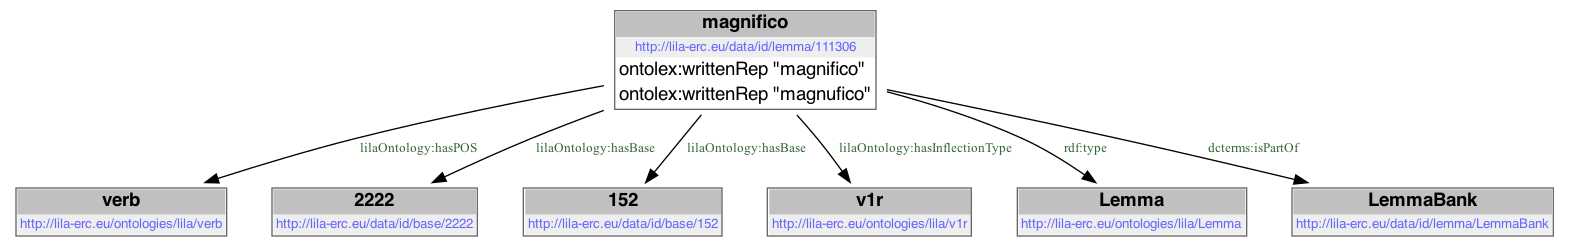

In [10]:
display(Image("magnifico.png"))

All the connections shown in the image are available via dedicated properties (apart from the link to the LemmaBank: see below). Keep in mind that most of those (with the exception of the part of speech and the inflection type) have a potential cartinality greater than 1, and therefore they return a tuple (which my also be empty). Thus, for instance, to get the property `lila:hasInflectionType` ('http://lila-erc.eu/ontologies/lila/hasInflectionType):

In [11]:
l.inflection_type

rdflib.term.URIRef('http://lila-erc.eu/ontologies/lila/v1r')

That's right, the verb belongs to the first conjugation (`v1r`). Below, we'll see how to get all fist-conj. lemmas from the lemma bank

### Derivational Morphology

LiLa holds two different representations of the derivational processes in Latin. One is linked to the lemmas themselves. At this level, all lemmas of the Classical Latin portion of the Lemma Bank are segmented into their morphome components, which can be of 2 (or 3, if you consider how the first class is split) types:
* affixes, i.e.:
    * prefixes
    * suffixes
* lexical bases

[Lexical Bases](http://lila-erc.eu/lodview/ontologies/lila/Base) are those lexical morphemes that are left once all prefixes and suffixes are stripped down. Take the English word *reunification* for instance. Once you remove the prefix *re-*, the suffix *-tion*, and the suffix *-fic/fy*, you are left with the lexical base commun to all words of the {union} family (*union, unity, unite*...). \[Note, however, that in Latin we treat the *-fic-* component as a second lexical base of the family of {facio}\].

This is great, but it won't tell you how you derive a word from another (e.g. *magnificatio* from *magnifico*): this is done in a dedicated lexical resource called *Word Formation Latin* or [WFL](http://lila-erc.eu/data/lexicalResources/WFL/Lexicon), which we'll see in detail when we talk about Lexical Resources.

For now, let's explore the first type of representation of Latin derivational morphology. As it is visible from the image above, we have a couple of properties, which are once again reachable from object properties:

In [12]:
l.lexical_bases

(rdflib.term.URIRef('http://lila-erc.eu/data/id/base/2222'),
 rdflib.term.URIRef('http://lila-erc.eu/data/id/base/152'))

Our lemma is only linked to two lexical bases: the one of *magnus* and the one of *facio*. No affixes, as can be seen by e.g. running:

In [13]:
l.suffixes

()

It would be great if we could have all the lemmas that share the same bases/affixes/prefixes as our given lemma! Well, we can. We can use 3 dedicated methods. Note that the methods do little more than running a SPARQL query, which is designed so that the starting lemma is *NOT* included in the results.

In [14]:
same_bases = l.get_lemmas_from_same_bases()

As we're dealing with the base of *facio* and the base of *magnus*, expect *a lot* of results!

In [15]:
len(same_bases)

770

Keep in mind that all we have here is an array of URIs, i.e. glorified strings: there's not much than we can do with them. Unless, of course, we construct a Lemma instance from each of them. However, that can be time- and resource-consuming: there may be better ways to achieve whatever you're after...

In [16]:
print(same_bases[0])
print(type(same_bases[0]))

http://lila-erc.eu/data/id/lemma/100086
<class 'rdflib.term.URIRef'>


If you want to see a suffix in action... keep reading!

But, before we get to that, what if we want *only* one of the two bases? For the results above mix both the facio and the magnus base...

In that case, you're better served by creating a generic LiLa Resource instance (the class from which *all* the objects in the `pylila` inherit), passing the URI of the base you're interest in to the constructor:

In [17]:
from pylila.resources import LiLaRes

# we use the first base linked to 'magnifico', whatever that is
b = LiLaRes(l.lexical_bases[0])

# Let's print the label
# you can rest pretty much assured that LiLa's resources will all have 1 and only 1 rdfs:label!

print(b.labels[0])

Base of magnus


Now we can use a dedicated method get the *inverse* graph, i.e. the graph made of all triples where the given resource is an object. (**Warning**: some resources are the target of *a lot* of relations; it may take a while...)

In [18]:
inv_g = b.get_inverse_graph()
len(inv_g)

27

Now let's use a method of `rdflib.Graph` to print all the subjects of a property-object pair. But first, in order to build the URI of the `lila:hasBase` property, let us import the `lila` namespace from the `pylila.urirefs` module, which conveniently provides some of the most used namespaces and URIs in LiLa

In [20]:
from pylila.urirefs import lila

hasbase = lila.hasBase
for sbj in inv_g.subjects(hasbase, b.uri):
    print(sbj)

http://lila-erc.eu/data/id/lemma/111307
http://lila-erc.eu/data/id/lemma/111295
http://lila-erc.eu/data/id/lemma/111297
http://lila-erc.eu/data/id/lemma/111298
http://lila-erc.eu/data/id/lemma/111299
http://lila-erc.eu/data/id/lemma/111300
http://lila-erc.eu/data/id/lemma/111292
http://lila-erc.eu/data/id/lemma/111293
http://lila-erc.eu/data/id/lemma/111294
http://lila-erc.eu/data/id/lemma/111310
http://lila-erc.eu/data/id/lemma/111313
http://lila-erc.eu/data/id/lemma/111319
http://lila-erc.eu/data/id/lemma/113281
http://lila-erc.eu/data/id/lemma/113287
http://lila-erc.eu/data/id/lemma/117051
http://lila-erc.eu/data/id/lemma/117052
http://lila-erc.eu/data/id/lemma/111303
http://lila-erc.eu/data/id/lemma/111304
http://lila-erc.eu/data/id/lemma/111305
http://lila-erc.eu/data/id/lemma/111306
http://lila-erc.eu/data/id/lemma/111317
http://lila-erc.eu/data/id/lemma/111318
http://lila-erc.eu/data/id/lemma/63173
http://lila-erc.eu/data/id/lemma/111311
http://lila-erc.eu/data/id/lemma/111314
h

### Get lemmas from string

Say that we want to see a `Suffix` in action, and our example above suggested the word [*magnificatio*](https://logeion.uchicago.edu/magnificatio) to us. From the same module `pylila.lemma` we can import a function to scan the Lemma Bank for lemmas that have the written representation that we're interested in.

For many, many reasons (including actual ambiguity as with Lat. *tempus*, or because there are - alas! - still duplicate left in the Lemma Bank), there may be more than one lemma that satisfy our query, so the function always returns a list!

In [21]:
from pylila.lemma import get_lemmas_by_writtenrep

magfi_list = get_lemmas_by_writtenrep('magnificatio')
magfi_list

['http://lila-erc.eu/data/id/lemma/111305']

Well, in this case we got pretty lucky! We found exactly what we were looking for. Let's build a Lemma instance out of our result:

In [17]:
magfi = Lemma(magfi_list[0])
magfi.get_written_representations()

'magnificatio'

And now the suffix!

In [22]:
magfi.suffixes

(rdflib.term.URIRef('http://lila-erc.eu/data/id/suffix/2'),)

In [24]:
# in case we want to look it up on the web:
print(magfi.suffixes[0])

http://lila-erc.eu/data/id/suffix/2


How do we know it's a suffix? Same as before: let's build a generic resource and check the `rdf:type`:

In [25]:
s = LiLaRes(magfi.suffixes[0])

print(s.types)
print(s.labels[0])

(rdflib.term.URIRef('http://lila-erc.eu/ontologies/lila/Suffix'),)
-(t)io(n)
